In [1]:
# If running on Google Colab, only cleverhans needs installation. This can be done via:
!pip install cleverhans

# If running locally, we've listed (TODO) our dependencies in requirements.txt, so the following
# should get everything up and running:
# !pip install -r requirements.txt

import numpy
import keras
import pandas
import requests
import io
import zipfile
import os
import re
import cleverhans
import tensorflow
import seaborn
import sklearn

from cleverhans.attacks import FastGradientMethod
from cleverhans.attacks import CarliniWagnerL2
from cleverhans.attacks import SaliencyMapMethod
from cleverhans.attacks_tf import jacobian_augmentation
from cleverhans.attacks_tf import jacobian_graph
from cleverhans.loss import CrossEntropy
from cleverhans.train import train
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.utils_tf import model_eval

from keras.models import Sequential
from keras.layers import Dense

numpy.random.seed(0xC0FFEE)
tensorflow.set_random_seed(0xC0FFEE)
rng = numpy.random.RandomState(0xC0FFEE)

    100% |████████████████████████████████| 204kB 22.2MB/s 
    100% |████████████████████████████████| 51kB 21.6MB/s 


Using TensorFlow backend.



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Dataset

## Loading data

Run the below code to download a copy of the dataset (if you don't already have it):

In [0]:
response = requests.get("http://www.schonlau.net/masquerade/masquerade-data.zip")

dataset_file = io.BytesIO(response.content)

zipped_dataset = zipfile.ZipFile(dataset_file)
zipped_dataset.extractall('data/masquerade-data')

In [0]:
# http://www.schonlau.net/intrusion.html
# download Masquerade Data (zip File)

import pandas as pd
directory = './data/masquerade-data'

In [0]:
def sorted_nicely( l ):
    """ Sorts the given iterable in the way that is expected.
 
    Required arguments:
    l -- The iterable to be sorted.
 
    """
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key = alphanum_key)

In [0]:
users = range(1,51)
df = pd.DataFrame()

for filename in sorted_nicely(os.listdir(directory)):
    user = pd.read_csv(os.path.join(directory, filename), header=None)
    df = pd.concat([df, user], axis = 1)
    
df.columns = sorted_nicely(os.listdir(directory))

We've loaded in the dataset, but need to do a little coercion to get it into the required format. First, we make sure  the values in the dataframe are categorical variables sharing the same data type:

In [0]:
commands = numpy.unique(df)
command_dtype = pandas.api.types.CategoricalDtype(commands)

for column in df:
    df[column] = df[column].astype(command_dtype)

In [0]:
labelled, unlabelled = df.head(5000), df.tail(len(df) - 5000)  # ignore unlabeled

The dataset contains a list of commands run for each user. Treating this as a timeseries, we perform rolling window sampling in blocks of 100 commands, and summarise the usage over each block.

In [0]:
def rolling_window_command_counts(commands, window_size):
    
    # Save a copy the name of the series to add again to our output. This will preserve the mapping of
    # user identifier to (it's column header in the dataframe it came from), which in
    # this case is the user identifier. 
    user = commands.name

    # Convert the single column "which command was run?" to a column for each
    # command, which says "was command <x> run?"
    commands = pandas.get_dummies(commands)

    # Take a rolling sample of the last 100 commands, then sum each "was command <x> run?"
    # columns to give a bunch "command <x> was run <y> times in this window".
    command_counts = commands.rolling(window=window_size).aggregate(numpy.sum)

    # Remove the first 100 rows because they contain data from blocks of size < 100.
    command_counts = command_counts[window_size-1:]
    
    # Preserve the user identifier (see top of function) as a new column:
    
    # First, a nasty hack: https://github.com/pandas-dev/pandas/issues/19136
    command_counts = command_counts.rename(columns=str)  
    
    # Then, add in the user (with an adhoc parser to turn the label into a number)
    command_counts['user'] = int(user.replace('User', ''))

    return command_counts

Apply to the entire dataset:

In [9]:
labelled_dataset = pandas.concat([
        rolling_window_command_counts(commands, 100)
        for user, commands in labelled.iteritems()
    ],
    ignore_index=True,  # reset index to go from 0 to 4900
)

labelled_dataset

,%backup%,.java_wr,.maker_w,.wrapper,.xinitrc,.xsessio,1.1,1.2,1.3,4Dwm,...,xxx,yacc,ypcat,yppasswd,z,zip,zsh,zubs,zz2,user
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [0]:
labels = labelled_dataset['user'] - 1
dataset = labelled_dataset.drop(columns=['user'])

In [0]:
labels =  keras.utils.to_categorical(labels, num_classes=50)

Creating the training and testing datasets:

In [0]:
from sklearn.model_selection import train_test_split

training_data, testing_data, training_labels, testing_labels = train_test_split(
    dataset,
    labels, 
    test_size=0.10,
)

# Building the Oracle

Following the architecture described in Ryan et al 1998, we create a three-layer backpropagation neural network using Keras.

In [0]:
oracle = Sequential()

In [0]:
input_layer = Dense(
    units=856,
    activation='relu',
    input_dim=856,
)

In [0]:
hidden_layer = Dense(
    units=30,
    activation='relu',
)

In [0]:
output_layer = Dense(
    units=50,
    activation='softmax',
)

In [17]:
oracle.add(input_layer)
oracle.add(hidden_layer)
oracle.add(output_layer)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
oracle.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

# Training Oracle on Dataset

Next, we train the neural network intrusion detection system:

In [19]:
history = oracle.fit(training_data,  training_labels, epochs=3, batch_size=50, validation_data = (testing_data, testing_labels), shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 220545 samples, validate on 24505 samples
Epoch 1/3
220545/220545 [==============================] - 80s 365us/step - loss: 0.1845 - acc: 0.9469 - val_loss: 0.0677 - val_acc: 0.9771
Epoch 2/3
220545/220545 [==============================] - 77s 349us/step - loss: 0.0643 - acc: 0.9780 - val_loss: 0.0468 - val_acc: 0.9822
Epoch 3/3
220545/220545 [==============================] - 75s 342us/step - loss: 0.0610 - acc: 0.9819 - val_loss: 0.0378 - val_acc: 0.9858


The trainingn ends with 98.58% accuracy against the test set. Here, we plot it's accuracy over time:

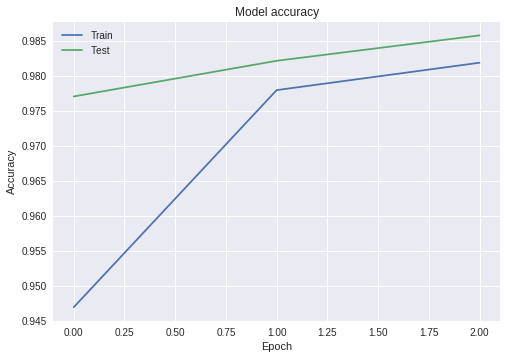

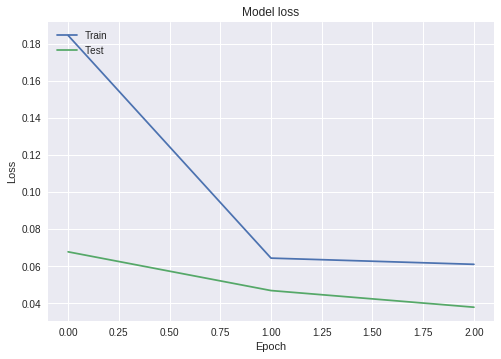

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Building a Substitute Model
First, mirror the architecture of the oracle:
    

In [0]:
substitute = Sequential()

input_layer = Dense(
    units=856,
    activation='relu',
    input_dim=856,
)
hidden_layer = Dense(
    units=30,
    activation='relu',
)
output_layer = Dense(
    units=50,
    activation='softmax',
)

substitute.add(input_layer)
substitute.add(hidden_layer)
substitute.add(output_layer)

# We need to convert our substitute model into the cleverhans format.
substitute = KerasModelWrapper(substitute)

In [0]:
tensorflow_session = tensorflow.Session()

We start by giving the adversary a small dataset to bootstrap its search. We give it a random sample of 5% of the original data set. 


In [24]:
adversary_training_set, adversary_test_set = train_test_split(
    labelled_dataset,
    train_size=0.05,
    stratify=labelled_dataset['user'],
)

adversary_training_inputs = adversary_training_set.drop('user', axis='columns')
adversary_training_labels = adversary_training_set['user'] - 1  # keras requires 0 based index

# For some reason cleverhans doesn't detect a GPU when it runs, but our models at the top using
# keras _do_. I think this creates a type mis-match: code running on the GPU uses numpy.float64
# whilst the cleverhans stuff runs on the CPU and extects numpy.float32 (or vica versa).
adversary_training_inputs = adversary_training_inputs.values.astype(numpy.float32)
adversary_training_labels = adversary_training_labels.values

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Define symbolic input placeholders for use in Tensor Flow:

In [0]:
number_of_users = 50
number_of_commands = 856

input_placeholder = tensorflow.placeholder(
    tensorflow.float32,
    shape=(None, number_of_commands)
)

output_placeholder = tensorflow.placeholder(
    tensorflow.float32,
    shape=(None, number_of_users)
)

Get the oracle's predictions for the bootstrap inputs:

In [0]:
bootstrap_oracle_predictions = oracle.predict(adversary_training_inputs)

Train substitute using Jacobian Dataset Augmentation:

In [0]:
# Define the predictions and loss of the model, symbolically in TensorFlow (i.e. these variables 
# point to the result of calculations that haven't been performed yet)

substitute_predictions = substitute.get_logits(input_placeholder)
substitute_loss = CrossEntropy(substitute, smoothing=0)

In [0]:
# Define the Jacobian symbolically using TensorFlow
grads = jacobian_graph(substitute_predictions, input_placeholder, number_of_users)

number_of_dataset_augmentation_batches = 5
dataset_augmentation_batch_size = 512


stepsize = 1  # this is the step-size of the Jacobian augmentation (we are working in ints so use 1).


# Train the substitute and augment dataset
for batch in range(number_of_dataset_augmentation_batches):
    print("BATCH #" + str(batch))
    
    print("Substitute training epoch:")
    train(
        tensorflow_session, 
        substitute_loss,
        adversary_training_inputs, 
        keras.utils.to_categorical(adversary_training_labels, num_classes=50),
        init_all=False,
        args={
            'nb_epochs': 10,
            'batch_size': 32,
            'learning_rate': 0.001,
        },
        rng=rng,
    )
    

    # If we are not at last substitute training iteration, augment dataset
    in_final_batch = batch == number_of_dataset_augmentation_batches - 1
    if not in_final_batch:
        print("Generating new data points:")
        
        # Use Jacobian augmentation to generate new data points:
        step_coef = 2 * int(int(batch / 3) != 0) - 1 

        augmented_dataset_inputs = jacobian_augmentation(
            tensorflow_session, 
            input_placeholder, 
            adversary_training_inputs, 
            adversary_training_labels,
            grads,
            step_coef * stepsize,
            dataset_augmentation_batch_size,
        )
        new_datapoints = augmented_dataset_inputs[len(adversary_training_inputs):]

        # Send the newly generated data points to the oracle, and use its output as their labels:
        new_labels = oracle.predict(new_datapoints)

        # Use argmax to get the most likely label. This follows the blackbox attack model - the
        # substitute shouldn't be able to see exact prediction confidence.
        new_labels = numpy.argmax(new_labels, axis=1)

        augmented_dataset_labels = numpy.hstack([adversary_training_labels, new_labels])

        # Replace dataset and labels with augmented dataset and labels
        adversary_training_inputs = augmented_dataset_inputs
        adversary_training_labels = augmented_dataset_labels

BATCH #0
Substitute training epoch:
Instructions for updating:
dim is deprecated, use axis instead
num_devices:  1


/usr/local/lib/python3.6/dist-packages/cleverhans/utils_tf.py:511: UserWarning: No GPUS, running on CPU
  warnings.warn("No GPUS, running on CPU")
[INFO 2019-03-18 15:01:45,689 cleverhans] Epoch 0 took 2.0771210193634033 seconds
[INFO 2019-03-18 15:01:47,819 cleverhans] Epoch 1 took 1.9393043518066406 seconds
[INFO 2019-03-18 15:01:49,957 cleverhans] Epoch 2 took 1.9512372016906738 seconds
[INFO 2019-03-18 15:01:51,987 cleverhans] Epoch 3 took 1.8366508483886719 seconds
[INFO 2019-03-18 15:01:54,105 cleverhans] Epoch 4 took 1.9322068691253662 seconds
[INFO 2019-03-18 15:01:56,228 cleverhans] Epoch 5 took 1.9418976306915283 seconds
[INFO 2019-03-18 15:01:58,237 cleverhans] Epoch 6 took 1.8289566040039062 seconds
[INFO 2019-03-18 15:02:00,328 cleverhans] Epoch 7 took 1.9082238674163818 seconds
[INFO 2019-03-18 15:02:02,449 cleverhans] Epoch 8 took 1.9298672676086426 seconds
[INFO 2019-03-18 15:02:04,535 cleverhans] Epoch 9 took 1.903015375137329 seconds


Generating new data points:
BATCH #1
Substitute training epoch:
num_devices:  1


[INFO 2019-03-18 15:02:35,025 cleverhans] Epoch 0 took 4.265499114990234 seconds
[INFO 2019-03-18 15:02:39,431 cleverhans] Epoch 1 took 3.966740369796753 seconds
[INFO 2019-03-18 15:02:44,056 cleverhans] Epoch 2 took 4.188504457473755 seconds
[INFO 2019-03-18 15:02:48,267 cleverhans] Epoch 3 took 3.7840728759765625 seconds
[INFO 2019-03-18 15:02:52,730 cleverhans] Epoch 4 took 4.039032220840454 seconds
[INFO 2019-03-18 15:02:56,880 cleverhans] Epoch 5 took 3.7284364700317383 seconds
[INFO 2019-03-18 15:03:01,341 cleverhans] Epoch 6 took 4.043584823608398 seconds
[INFO 2019-03-18 15:03:05,763 cleverhans] Epoch 7 took 3.999586343765259 seconds
[INFO 2019-03-18 15:03:10,156 cleverhans] Epoch 8 took 3.9749202728271484 seconds
[INFO 2019-03-18 15:03:14,257 cleverhans] Epoch 9 took 3.680140733718872 seconds


Generating new data points:
BATCH #2
Substitute training epoch:
num_devices:  1


[INFO 2019-03-18 15:04:15,706 cleverhans] Epoch 0 took 8.24474573135376 seconds
[INFO 2019-03-18 15:04:24,634 cleverhans] Epoch 1 took 7.891599893569946 seconds
[INFO 2019-03-18 15:04:33,035 cleverhans] Epoch 2 took 7.477725505828857 seconds
[INFO 2019-03-18 15:04:41,251 cleverhans] Epoch 3 took 7.287150621414185 seconds
[INFO 2019-03-18 15:04:49,604 cleverhans] Epoch 4 took 7.430698394775391 seconds
[INFO 2019-03-18 15:04:57,749 cleverhans] Epoch 5 took 7.225452661514282 seconds
[INFO 2019-03-18 15:05:05,951 cleverhans] Epoch 6 took 7.276463270187378 seconds
[INFO 2019-03-18 15:05:14,135 cleverhans] Epoch 7 took 7.269887924194336 seconds
[INFO 2019-03-18 15:05:22,527 cleverhans] Epoch 8 took 7.476808071136475 seconds
[INFO 2019-03-18 15:05:30,764 cleverhans] Epoch 9 took 7.311864376068115 seconds


Generating new data points:


## Evaluating Substitute Model

Here we evaluate the substitute against the 95% of the dataset it hasn't seen.

In [0]:
adversary_test_inputs = adversary_test_set.drop('user', axis='columns')
adversary_test_labels = adversary_test_set['user'] - 1  # keras requires 0 based index

# For some reason cleverhans doesn't detect a GPU when it runs, but our models at the top using
# keras _do_. I think this creates a type mis-match: code running on the GPU uses numpy.float64
# whilst the cleverhans stuff runs on the CPU and expects numpy.float32 (or vica versa).
adversary_test_inputs = adversary_test_inputs.values.astype(numpy.float32)
adversary_test_labels = adversary_test_labels.values

First, check its accuracy against the true labels:

In [34]:
adversary_test_labels_one_hot = keras.utils.to_categorical(adversary_test_labels, num_classes=50)

# Evaluate the substitute model on clean test examples against true labels
acc = model_eval(
    tensorflow_session, 
    input_placeholder,
    output_placeholder,
    substitute_predictions,
    adversary_test_inputs,
    adversary_test_labels_one_hot,
    args={'batch_size': 32}
)
acc

0.948801106538716

Next, send this test dataset into the oracle to get it's predictions. Then, compare the substitute models  predctions against those of the oracle. This is important, as it allows us to measure: how good of an imitatin of the oracle our substitute is.

In [35]:
oracle_predicted_labels = oracle.predict(adversary_test_inputs)

# Evaluate the substitute model on clean test examples against oracle's labels
acc = model_eval(
    tensorflow_session, 
    input_placeholder,
    output_placeholder,
    substitute_predictions,
    adversary_test_inputs,
    oracle_predicted_labels,
    args={'batch_size': 32}
)
acc

0.9488182888169142

TODO: How do these two accuracies compare? What does that mean about our substitute? What does that say about our oracle?)

## Inspecting the Synthetic Dataset

Just inspecting the generated dataset. Notes:
  1. Some of the values are negative!
  2. The real dataset has an input range of 0-100. This search technique has found all of them, plus a few on each side.
  3. The augmented dataset has just less than 200,000 data points. That's almost as many as were used to train the oracle.

In [36]:
numpy.unique(adversary_training_inputs)

array([ -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,
         7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,
        18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,
        29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,
        40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,
        51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,
        62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,
        73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
        84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,
        95.,  96.,  97.,  98.,  99., 100., 101.], dtype=float32)

In [37]:
len(adversary_training_inputs)

196032

In [38]:
pandas.DataFrame(adversary_training_inputs[numpy.random.choice(adversary_training_inputs.shape[0], size=20)])

,0,1,2,3,4,5,6,7,8,9,...,846,847,848,849,850,851,852,853,854,855
0,-1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,...,4.0,1.0,1.0,1.0,1.0,1.0,3.0,-1.0,1.0,1.0
1,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,2.0,-2.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0
2,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,...,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0
3,-3.0,-1.0,-1.0,1.0,3.0,3.0,1.0,1.0,-1.0,1.0,...,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,3.0,-1.0
4,0.0,0.0,2.0,0.0,-2.0,0.0,-2.0,-2.0,-2.0,2.0,...,2.0,2.0,0.0,2.0,-2.0,2.0,-2.0,-2.0,2.0,2.0
5,-1.0,1.0,-1.0,1.0,5.0,1.0,-1.0,1.0,-1.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0
6,-3.0,3.0,-1.0,1.0,1.0,-1.0,-1.0,3.0,-1.0,5.0,...,3.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,3.0,-1.0
7,-3.0,1.0,-1.0,-1.0,1.0,1.0,-3.0,3.0,-3.0,3.0,...,2.0,-3.0,1.0,-1.0,-1.0,3.0,-1.0,1.0,3.0,1.0
8,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,...,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0
9,-1.0,1.0,-1.0,-1.0,3.0,1.0,-1.0,-3.0,-1.0,1.0,...,-1.0,3.0,-1.0,-1.0,-3.0,1.0,-1.0,-1.0,1.0,-1.0


# Crafting Adversarial Examples

First we build an attack using the Fast Gradient Sign method. This attack is then used to generate untargeted adversarial examples for each value in our test set.

In [0]:
# Initialize the Fast Gradient Sign Method (FGSM) attack object.
fgsm_par = {'eps': 1., 'ord': numpy.inf, 'clip_min': 0., 'clip_max': 100.}
fgsm = FastGradientMethod(substitute, sess=tensorflow_session)

In [40]:
# Craft adversarial examples using the substitute
eval_params = {'batch_size': dataset_augmentation_batch_size}
x_adv_sub = fgsm.generate(input_placeholder, **fgsm_par)

Instructions for updating:
Use tf.cast instead.


In [41]:
x_adv_sub

<tf.Tensor 'Identity:0' shape=(?, 856) dtype=float32>

In [0]:
oracle_keras = KerasModelWrapper(oracle)
oracle_fgsm_pred = oracle_keras.get_logits(x_adv_sub)

In [91]:
oracle_fgsm_pred

TensorShape([Dimension(None), Dimension(50)])

In [44]:
# Evaluate the accuracy of the "black-box" model on adversarial examples
accuracy = model_eval(
        tensorflow_session,
        input_placeholder,
        output_placeholder,
        oracle_fgsm_pred,
        adversary_test_inputs,
        adversary_test_labels_one_hot,
        args=eval_params
)
print('Test accuracy of oracle on adversarial examples generated '
    'using the substitute: ' + str(accuracy))

Test accuracy of oracle on adversarial examples generated using the substitute: 0.01817025919466662


In the above we have shown that the accuracy of the oracle is reduced to 1.6% when using our minimally changed command vectors! This is an example of an untargeted attack: all we are trying to do is get the oracle to misclassify a datapoint as a user which we believe truly represents a different user.

### Targetting Particular Users

Pick an example command vector which wasn't user 2, then generate a similar example that is classified as user 2. 

We then put that example into the oracle model and check it's classification. If it is classified as user 2, our attempt was successfull.

In [45]:
original_command_vectors = numpy.array([adversary_test_inputs[0]])
original_labels = numpy.array([adversary_test_labels_one_hot[0]])

target_labels = keras.utils.to_categorical(numpy.array([2]), num_classes=50)

fgsm_attack = FastGradientMethod(substitute, sess=tensorflow_session)
fgsm_params = {
    'eps': 1.0,
    'ord': numpy.inf,
    'clip_min': 0.0,
    'clip_max': 100.0,
}
adversarial_examples = fgsm_attack.generate_np(
    original_command_vectors,
    y_target=target_labels,
    **fgsm_params,
)

predicted_labels = oracle.predict(adversarial_examples)

print("original label = {}".format(adversary_test_labels[0]))
print("predicted label = {}".format(numpy.argmax(predicted_labels[0])))
print("prediction certainty = {}".format(numpy.max(predicted_labels[0])))

[INFO 2019-03-18 13:32:46,895 cleverhans] Constructing new graph for attack FastGradientMethod


original label = 43
predicted label = 26
prediction certainty = 1.0


Whilst  the above demonstrates the attacks effectiveness with one particular example, targetted against one particular user, we should be sure to evaluate the attacks efffectiveness in general.

In fact, it is most often the case that the fast gradient sign method is able to generate successful adversarial examples based on a particular starting vector, and a particular target user.

We define a function below to take in one particular command vector, and perform a targeted attack against each of the users.

In [0]:
def run_targeted_attack_against_all_users(command_vector, label, attack, attack_params):
    """
    Runs a targeted attack for the given sample against. For each user, we attempt to generate a
    similar command vector to the original, which is classified as that user.
    
    The command prints a summary of the results to stdout, then returns a dataframe containing, 
    for each attack:
      - the original user
      - the targeted user
      - the oracle models prediction against the adversarial example
      - the oracles certainty of that prediction
    """    
    
    # Since we run this once against all users, make 50 replicas of the command vector, and
    # original label:
    original_label_one_hot = keras.utils.to_categorical(label, num_classes=50)
    original_labels = numpy.tile(original_label_one_hot, reps=(50,1))
    
    original_command_vectors = numpy.tile(command_vector, reps=(50, 1))
    
    # Our target labels are the one-hot-encoded values 0, 1, 2, ..., 49:
    target_labels = keras.utils.to_categorical(range(50), num_classes=50)

    attack_params['y_target'] = target_labels
    
    # Apply the attack, generating the adversarial examples:
    adversarial_examples = attack.generate_np(
        original_command_vectors,
        **attack_params,
    )

    # Stick these examples into the oracle, and find out what classification it gives:
    predictions = oracle.predict(adversarial_examples)

    # Format the results into a summary dataframe:
    original_label = pandas.Series(
        numpy.apply_along_axis(numpy.argmax, axis=1, arr=original_labels), # undo one hot encode
        name='Original User',
    )
    target_label = pandas.Series(
        numpy.apply_along_axis(numpy.argmax, axis=1, arr=target_labels), # undo one hot encode
        name='Target User',
    )
    predicted_label = pandas.Series(
        numpy.apply_along_axis(numpy.argmax, axis=1, arr=predictions),  # undo one hot encode
        name='Oracle Prediction',
    )
    prediction_certainty = pandas.Series(
        numpy.apply_along_axis(numpy.max, axis=1, arr=predictions),
        name='Oracle Certainty',
    )

    summary = pandas.concat(
        [
            original_label,
            target_label,
            predicted_label,
            prediction_certainty,
        ],
        axis='columns',
    )
    
    # Count the number of targeted attacks which were succcessful:
    successful_attacks = summary.apply(lambda row: row[1] == row[2], axis='columns').sum()
    
    # Don't count  the original_user -> original_user attack:
    successful_attacks -= 1 
    total_attacks = 49
    
    # Print out a little message to say how we did :)
    print(
        "A targeted attack was successful against {}/{} users (with the given input):"
        .format(successful_attacks, total_attacks)
    )

    return summary, adversarial_examples

For example, below we take a command vector not yet seen by the substitute model and try to craft adversarial examples targeted at each user. As you can see, the attack is relatively sucessful!

In [47]:
summary, _ = run_targeted_attack_against_all_users(
    adversary_test_inputs[0],
    adversary_test_labels[0],
    fgsm_attack,
    fgsm_params,
)
summary

A targeted attack was successful against 2/49 users (with the given input):


,Original User,Target User,Oracle Prediction,Oracle Certainty
0,43,0,26,1.000000
1,43,1,26,1.000000
2,43,2,26,1.000000
3,43,3,26,0.999998
4,43,4,26,0.999997
5,43,5,26,0.999997
6,43,6,26,1.000000
7,43,7,26,0.999998
8,43,8,26,1.000000
9,43,9,9,0.999068


In [48]:
def evaluate_targetted_attack(test_inputs, test_labels, attack):
    # For each test input, duplicate it 50 times, once for each potential target user 0, 1, ... 49
    # Input all of these into the attack and get outputs
    # Count rows for which target_user == oracle_prediction
    # Divide by total rows
    
    
    # Since we run this once against all users, make 50 replicas of the command vector, and
    # original label:
    original_label_one_hot = keras.utils.to_categorical(label, num_classes=50)
    original_labels = numpy.tile(original_label_one_hot, reps=(50,1))
    
    original_command_vectors = numpy.tile(command_vector, reps=(50, 1))
    
    # Our target labels are the one-hot-encoded values 0, 1, 2, ..., 49:
    target_labels = keras.utils.to_categorical(range(50), num_classes=50)

    attack_params['y_target'] = target_labels
    
    # Apply the attack, generating the adversarial examples:
    adversarial_examples = attack.generate_np(
        original_command_vectors,
        **attack_params,
    )

    # Stick these examples into the oracle, and find out what clas

SyntaxError: ignored

### Custom Attack Method

The oracle model uses integers and absolute counts as inputs. In contrast to something like percentage inputs. This is quite succesfull in limiting effectiveness of our attacks, the results of which can  be seen above. 

A common approach to limiting adversarial attacks for image classifiers is to use thresholding. The use of integer inputs serves a simlar purpose in the original model. Simliarly, using absolute values severly limits our search space. When converting a naughty script, we aren't able to remove commands: we need them to perform our evil deeds! If the model took in percentage inputs (as a distribution) we would be able to to lower values by increasing all other values.

This combination makes the original model relatively resistant to standard attack methods. In this section we explore methods of overcoming these restrictions. In particular, we extend an attack originally proposed by Carlini and Wagner. It uses the Adam optimiser and prioritises accuracy over speed. We modify it's optimisation function such that it deprioritise negative perturbations.
  
In contrast to attacks against image classification models, our input does not need to look similar to a human. For this reason, we further modify the optimisation functions not to consider the size of positive perturbations.

Our optimisation functions considers the following most important:
  - no commands should be removed
  - it should classify as strongly as possible to the target class


In [0]:
# Just use CarliniWagnerL2 and see how it does

smm_attack = cleverhans.attacks.MomentumIterativeMethod(substitute, sess=tensorflow_session)
smm_params = {
    'eps': 100.0,
    'eps_iter': 1.0,
    'nb_iter': 100,
    'ord': 2,
    'clip_min': 0.0,
    'clip_max': 100.0,
}

summary, adversarial_examples = run_targeted_attack_against_all_users(adversary_test_inputs[0], adversary_test_labels[0], smm_attack, smm_params)
summary

In [0]:
def plot_command_vector(command_vector, danger=False):
    # reshape into a rectangle, and pad slightly beforehand
    rectangle_array= numpy.concatenate([command_vector, numpy.array([0,0])]).reshape((26,33))
    normalized_array = sklearn.preprocessing.normalize(rectangle_array)
    
    color = 'Reds' if danger else 'Greens'
    
    return seaborn.heatmap(
        normalized_array,
        square=True,
        xticklabels=False,
        yticklabels=False,
        vmin=0, 
        vmax=1,
        cmap=color,
    )

In [0]:
plot_command_vector(adversary_test_inputs[0])

In [0]:
 plot_command_vector(adversarial_examples[0])

In [0]:
 adversarial_examples[0] >= adversary_test_inputs[0]

### Additive-only Momentum Iterative Method

In [0]:
import tensorflow as tf

from cleverhans.attacks import optimize_linear
from cleverhans.compat import reduce_sum, reduce_mean, softmax_cross_entropy_with_logits
from cleverhans import utils_tf


class AdditiveMomentumIterativeMethod(cleverhans.attacks.MomentumIterativeMethod):
  """
  Modifies the The Momentum Iterative Method (Dong et al. 2017) to produce additive
  perturbations only.
  
  If it finds the optimal perturbation to be negative, a random addition is performed instead.
  
  Original paper link: https://arxiv.org/pdf/1710.06081.pdf
  
  :param model: cleverhans.model.Model
  :param sess: optional tf.Session
  :param dtypestr: dtype of the data
  :param kwargs: passed through to super constructor
  """

  def generate(self, x, **kwargs):
    """
    Generate symbolic graph for adversarial examples and return.
    :param x: The model's symbolic inputs.
    :param kwargs: Keyword arguments. See `parse_params` for documentation.
    """
    # Parse and save attack-specific parameters
    assert self.parse_params(**kwargs)

    asserts = []

    # If a data range was specified, check that the input was in that range
    if self.clip_min is not None:
      asserts.append(utils_tf.assert_greater_equal(x,
                                                   tf.cast(self.clip_min,
                                                           x.dtype)))

    if self.clip_max is not None:
      asserts.append(utils_tf.assert_less_equal(x,
                                                tf.cast(self.clip_max,
                                                        x.dtype)))

    # Initialize loop variables
    momentum = tf.zeros_like(x)
    adv_x = x

    # Fix labels to the first model predictions for loss computation
    y, _nb_classes = self.get_or_guess_labels(x, kwargs)
    y = y / reduce_sum(y, 1, keepdims=True)
    targeted = (self.y_target is not None)

    def cond(i, _, __):
      """Iterate until number of iterations completed"""
      return tf.less(i, self.nb_iter)

    def body(i, ax, m):
      """Do a momentum step"""
      logits = self.model.get_logits(ax)
      loss = softmax_cross_entropy_with_logits(labels=y, logits=logits)
      if targeted:
        loss = -loss

      # Define gradient of loss wrt input
      grad, = tf.gradients(loss, ax)

      # Normalize current gradient and add it to the accumulated gradient
      red_ind = list(range(1, len(grad.get_shape())))
      avoid_zero_div = tf.cast(1e-12, grad.dtype)
      grad = grad / tf.maximum(
          avoid_zero_div,
          reduce_mean(tf.abs(grad), red_ind, keepdims=True))
      m = self.decay_factor * m + grad

      optimal_perturbation = optimize_linear(m, self.eps_iter, self.ord)
      optimal_perturbation = tf.maximum(optimal_perturbation, tf.zeros_like(optimal_perturbation))
        
      if self.ord == 1:
        raise NotImplementedError("This attack hasn't been tested for ord=1."
                                  "It's not clear that FGM makes a good inner "
                                  "loop step for iterative optimization since "
                                  "it updates just one coordinate at a time.")

      # Update and clip adversarial example in current iteration
      ax = ax + optimal_perturbation
      ax = x + utils_tf.clip_eta(ax - x, self.ord, self.eps)

      if self.clip_min is not None and self.clip_max is not None:
        ax = utils_tf.clip_by_value(ax, self.clip_min, self.clip_max)

      ax = tf.stop_gradient(ax)

      return i + 1, ax, m

    _, adv_x, _ = tf.while_loop(
        cond, body, (tf.zeros([]), adv_x, momentum), back_prop=True,
        maximum_iterations=self.nb_iter)

    if self.sanity_checks:
      with tf.control_dependencies(asserts):
        adv_x = tf.identity(adv_x)

    return adv_x


In [54]:
ami_attack = AdditiveMomentumIterativeMethod(substitute, sess=tensorflow_session)
ami_params = {
    'eps': 100.0,
    'eps_iter': 1.0,
    'nb_iter': 100,
    'ord': numpy.inf,
    'clip_min': 0.0,
    'clip_max': 100.0,
}

summary, adversarial_examples = run_targeted_attack_against_all_users(
    adversary_test_inputs[0],
    adversary_test_labels[0],
    ami_attack,
    ami_params,
)
summary

[INFO 2019-03-18 14:00:09,219 cleverhans] Constructing new graph for attack AdditiveMomentumIterativeMethod


A targeted attack was successful against 23/49 users (with the given input):


,Original User,Target User,Oracle Prediction,Oracle Certainty
0,43,0,14,1.0
1,43,1,1,1.0
2,43,2,2,1.0
3,43,3,3,1.0
4,43,4,0,1.0
5,43,5,5,1.0
6,43,6,14,1.0
7,43,7,7,1.0
8,43,8,8,1.0
9,43,9,9,1.0


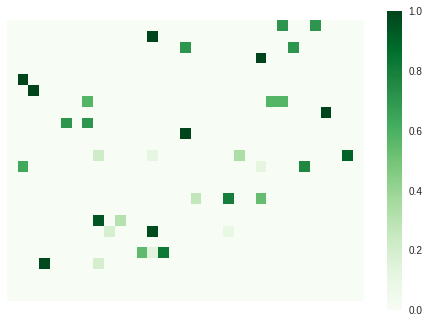

In [92]:
plot_command_vector(adversary_test_inputs[0])

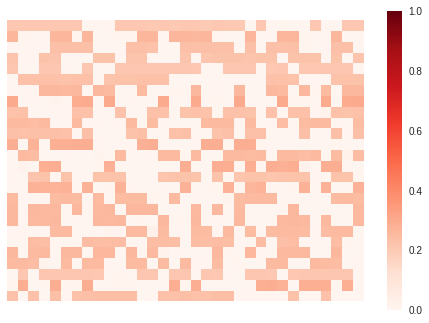

In [93]:
plot_command_vector(adversarial_examples[0], danger=True)

So our modified method gives much better results for targeted attacks, lets see how it compares for untargeted attacks. We have tried to do this below, but the commented part breaks.

In [0]:
# Craft adversarial examples using the substitute
x_adv_sub_ami = ami_attack.generate(input_placeholder, **ami_params)

In [82]:
x_adv_sub_ami

<tf.Tensor 'Identity_4:0' shape=(?, 856) dtype=float32>

In [0]:
oracle_ami_test = KerasModelWrapper(oracle)
oracle_ami_pred = oracle_ami_test.get_logits(x_adv_sub_ami)

In [95]:
adversary_test_labels_one_hot.shape, adversary_test_inputs.shape

((232798, 50), (232798, 856))

In [0]:
# # Evaluate the accuracy of the "black-box" model on adversarial examples
# untargetted_accuracy_ami = model_eval(
#         tensorflow_session,
#         input_placeholder,
#         output_placeholder,
#         oracle_ami_pred,
#         adversary_test_inputs,
#         adversary_test_labels_one_hot,
#         args=eval_params
# )
# print('Test accuracy of oracle on adversarial examples generated '
#     'using the substitute: ' + str(accuracy))

# An End-to-End Attack

In this section, we use the models and attacks developed above to perform a complete attack on the intrusion detection system.

First we define two functions:
  1. `script_to_command_vector` :: converts a list of bash commands into a command vector (as if it werre generated by `acct`).
  2. `pad_script` :: takes an input script and generats an output script with the same behaviour, but with the command counts specified by command_vector.

In [0]:
def script_to_command_vector(script):
    lines = script.split("\n")  # ['netscape', 'sh ./my-script.sh', ...]
    commands = [
        line.split(" ")[0] for line in lines
    ]  # ['netscape', 'sh', ...]
    
    commands = pandas.Series(commands).astype(command_dtype)
    commands_one_hot = pandas.get_dummies(commands)
    command_counts = commands_one_hot.sum()
    
    return command_counts

In [0]:
# For our proof-of-concept, just append --help to turn our commands into no-ops. This won't
# actually work for all of these commands, but proves the point.
COMMAND_TO_NOOP = {command: command + " --help" for command in commands}

def pad_script(original_script, target_command_counts):
    # First, calculate the command counts of the input script:
    original_command_counts = script_to_command_vector(original_script)
    
    # Find the number of each command we need to pad by:
    additional_command_counts = target_command_counts - original_command_counts
    
    # Loop over additional_command_counts and append no-op commands for each additional
    # command needed:
    
    # TODO: finish this
    padded_script = original_script
    
    return padded_script

In [0]:
def masq(script, target_user):
    command_vector = script_to_command_vector(script)
    original_command_vectors = numpy.array([command_vector])

    target_labels = keras.utils.to_categorical(numpy.array([target_user]), num_classes=50)

    attack = FastGradientMethod(substitute, sess=tensorflow_session)
    adversarial_examples = attack.generate_np(
        original_command_vectors,
        y_target=target_labels,
        eps=1.0,
        ord=numpy.inf,
        clip_min=0.0,
        clip_max=100.0,
    )

    predicted_labels = oracle.predict(adversarial_examples)
    
    adversarial_example = adversarial_examples[0]
    predicted_label = numpy.argmax(predicted_labels[0])
    
    if predicted_label == target_user:
        fool = 'We have fooled the model!'
    else:
        fool = 'We have failed to fool the model... oh dear.'
    
    print('These are the adversarial example that was generated: \n')
    print(str(adversarial_example))
    print('\n and this is the predicted user: \n')
    print(str(predicted_label))
    print('\n '+fool)


masq(
    script="""
        cat
        hostname
        awk
        stty
        tset
        sh
        chmod
        chmod
        chmod
        chmod
        news
        sh ./my-script.sh
        netstat
        netscape
        netscape
        netscape
        netscape
        netscape
        netscape
    """,
    target_user=16,    
    )